In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import xarray as xr
combined_ds = xr.open_dataset('data/combined_dataset.nc')
combined_ds_train = combined_ds.isel(time=slice(10, 1000))

combined_ds_test = combined_ds.isel(time=slice(3000, 3500))

print(f"Dataset now contains {len(combined_ds.time)} timesteps")
print(f"Time range: {combined_ds.time[0].values} to {combined_ds.time[-1].values}")

Dataset now contains 3288 timesteps
Time range: 2002-02-20T00:00:00.000000000 to 2022-12-31T00:00:00.000000000


In [3]:
len(combined_ds.time)

3288

In [19]:
combined_ds.isel(time=slice(10, 2000))

<xarray.Dataset> Size: 4GB
Dimensions:     (time: 1990, y: 448, x: 304)
Coordinates:
  * time        (time) datetime64[ns] 16kB 2012-02-21 2012-02-22 ... 2019-06-04
  * y           (y) float64 4kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * x           (x) float64 2kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
Data variables:
    F17_ICECON  (time, y, x) float64 2GB ...
    crs         (time) |S1 2kB ...
    F13_ICECON  (time, y, x) float64 2GB ...
Attributes: (12/49)
    title:                     Bootstrap Sea Ice Concentrations from Nimbus-7...
    summary:                   These sea ice concentration data were derived ...
    id:                        10.5067/X5LG68MH013O
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced by the NASA Cryospheri...
    metadata_link:             https://doi.org/10.5067/X5LG68MH013O
    ...                        ...
    geospatial_y_resolution:   25000.0 meters
    geospatial_lat_min:        30.980564
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    platform:                  DMSP 5D-3/F17 Defense Meteorological Satellite...

In [20]:
combined_ds.isel(time=slice(3000, 3500))

<xarray.Dataset> Size: 628MB
Dimensions:     (time: 288, y: 448, x: 304)
Coordinates:
  * time        (time) datetime64[ns] 2kB 2022-03-19 2022-03-20 ... 2022-12-31
  * y           (y) float64 4kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * x           (x) float64 2kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
Data variables:
    F17_ICECON  (time, y, x) float64 314MB ...
    crs         (time) |S1 288B ...
    F13_ICECON  (time, y, x) float64 314MB ...
Attributes: (12/49)
    title:                     Bootstrap Sea Ice Concentrations from Nimbus-7...
    summary:                   These sea ice concentration data were derived ...
    id:                        10.5067/X5LG68MH013O
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced by the NASA Cryospheri...
    metadata_link:             https://doi.org/10.5067/X5LG68MH013O
    ...                        ...
    geospatial_y_resolution:   25000.0 meters
    geospatial_lat_min:        30.980564
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    platform:                  DMSP 5D-3/F17 Defense Meteorological Satellite...

In [4]:
import torch
import torch.nn as nn

class DataGenerator:
    def __init__(self, dataset, sequence_length=5, step=1):
        self.dataset = dataset
        self.sequence_length = sequence_length
        self.step = step  # Step between days in sequence (1 for consecutive, 2 for every other day, etc)
        self.total_days = len(dataset.time)
        
    def __getitem__(self, idx):
        # Calculate total span needed for sequence with steps
        total_span = (self.sequence_length - 1) * self.step + self.step
        
        # Ensure we have enough days left to get sequence + label
        if idx > self.total_days - (total_span + 1):
            idx = np.random.randint(0, self.total_days - (total_span + 1))
            
        # Get sequence with specified step between days
        sequence_indices = [idx + (i * self.step) for i in range(self.sequence_length)]
        sequence = self.dataset.isel(time=sequence_indices)
        
        # Get the label as next step day after sequence
        # e.g. if sequence is days [1,3,5,7], label will be day 9
        label = self.dataset.isel(time=idx + total_span)
        # Convert to numpy arrays and select F17_ICECON variable
        X = sequence.F17_ICECON.values
        y = label.F17_ICECON.values
        
        # Add channel dimension for ConvLSTM (batch, time, channel, height, width)
        X = np.expand_dims(X, axis=1)
        y = np.expand_dims(y, axis=0)
        
        return torch.FloatTensor(X), torch.FloatTensor(y)
    
    def __len__(self):
        total_span = (self.sequence_length - 1) * self.step + 1
        return self.total_days - (total_span + 1)
    
    def get_random_sample(self):
        idx = np.random.randint(0, len(self))
        return self[idx]

# Create data generator instances and DataLoaders for train and test
train_generator = DataGenerator(combined_ds_train, sequence_length=1, step=1)
test_generator = DataGenerator(combined_ds_test, sequence_length=1, step=1)

batch_size = 8
train_loader = torch.utils.data.DataLoader(
    train_generator,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    test_generator,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

In [5]:
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class VAE(nn.Module):
    def __init__(self, input_channels=1):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # Calculate size after encoder convolutions
        self.enc_size = (256, 28, 19)  # Based on input 448x304
        self.fc_size = np.prod(self.enc_size)
        
        # Latent space
        self.fc_mu = nn.Linear(self.fc_size, 512)
        self.fc_var = nn.Linear(self.fc_size, 512)
        
        # Decoder input
        self.decoder_input = nn.Linear(512, self.fc_size)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        
    def encode(self, x):
        # Encode the last frame of the sequence
        x = x[:, -1]  # Take last frame from sequence
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(x.size(0), *self.enc_size)  # Reshape
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

def vae_loss(recon_x, x, mu, log_var):
    # Reconstruction loss (binary cross entropy)
    BCE = F.mse_loss(recon_x, x)
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return BCE + KLD

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [17]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [6]:
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class VAE(nn.Module):
    def __init__(self, input_channels=1):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=2, padding=1),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), 
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            # nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            # nn.BatchNorm2d(256),
            nn.ReLU(),
            # nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(256),
            # nn.ReLU(),
        )
        
        # Calculate size after encoder convolutions
        # Input: 448x304
        # After 5 stride-2 convs: 448/32=14, 304/32=9.5 (rounds down to 9)
        # Last encoder layer has 512 channels
        self.enc_size = (512, 28, 19)  # Channels, Height, Width
        self.fc_size = np.prod(self.enc_size)  # 256 * 14 * 10 = 71680
        
        # Latent space
        self.fc_mu = nn.Linear(self.fc_size, 512)  # Changed from fc_size to match flattened input
        self.fc_var = nn.Linear(self.fc_size, 512)  # Changed from fc_size to match flattened input
        
        # Decoder input
        self.decoder_input = nn.Linear(512, self.fc_size)
        
        # Decoder
        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=1),
            # # nn.BatchNorm2d(256),  
            # nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(64, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        
    def encode(self, x):
        # Encode the last frame of the sequence
        x = x[:, -1]  # Take last frame from sequence
        x = self.encoder(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(x.size(0), *self.enc_size)  # Reshape
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

def vae_loss(recon_x, x, mu, log_var):
    # weights = torch.ones_like(x)
    # weights[(x <= 1) & (x > 0)] = 1.0 
    # weights[~((x <= 1) & (x > 0))] = 0.1 

    MSE = F.mse_loss(recon_x, x)
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return MSE + KLD

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [17]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    for batch_idx, (X, y) in tqdm(enumerate(train_loader)):
        X = X.to(device)
        y = y.to(device)
        # y = torch.clamp(y, 0, 1)
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, log_var = model(X)
        
        # Calculate loss
        loss = vae_loss(recon_batch, y, mu, log_var)
        
        # Backward pass
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    avg_train_loss = train_loss / len(train_loader.dataset)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            # y = torch.clamp(y, 0, 1)
            recon_batch, mu, log_var = model(X)
            val_loss += vae_loss(recon_batch, y, mu, log_var).item()
            
    avg_val_loss = val_loss / len(test_loader.dataset)
    
    # Print metrics
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Average Train Loss: {avg_train_loss:.4f}')
    print(f'Average Val Loss: {avg_val_loss:.4f}')
    
    # # Optional: Save reconstructed images periodically
    # if (epoch + 1) % 10 == 0:
    #     with torch.no_grad():
    #         sample = X[:8]
    #         recon = model(sample)[0]
            # Save or display images here if desired


32it [01:49,  3.12s/it]

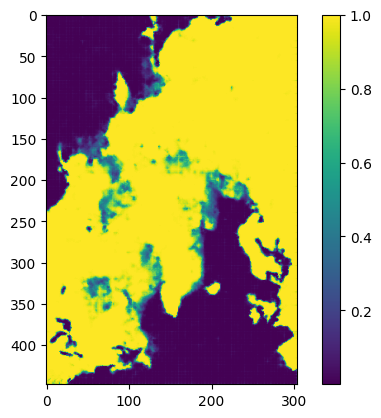

In [18]:
plt.imshow(recon_batch[0, 0, :, :].cpu().detach().numpy())
plt.colorbar()


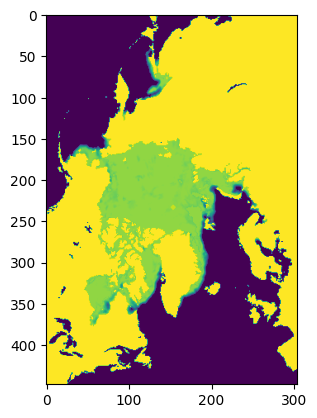

In [16]:
plt.imshow(y[0, 0, :, :].cpu().numpy())

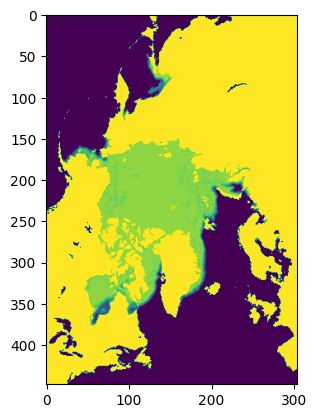

In [10]:
plt.imshow(X[0, 0, 0, :, :].cpu().numpy())

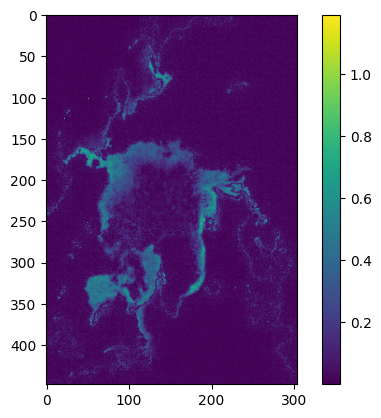

In [11]:
plt.imshow(abs(recon_batch[0, 0, :, :].cpu().numpy() - X[0, 0, 0, :, :].cpu().numpy()))
plt.colorbar()


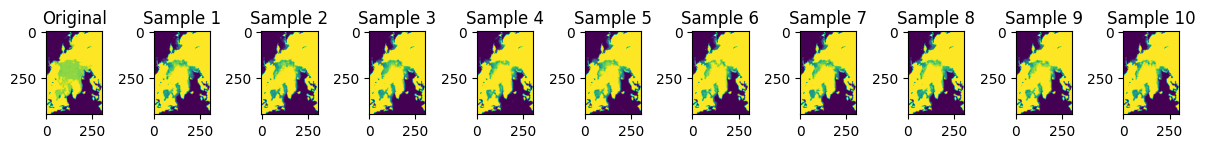

In [10]:
# Take a single image and encode it
with torch.no_grad():
    single_image = X[0:1]  # Keep batch dimension
    mu, log_var = model.encode(single_image)
    
    # Sample from the latent space multiple times
    decoded_samples = []
    num_samples = 10  # Generate 5 different samples
    
    for _ in range(num_samples):
        # Sample from the latent distribution
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        # Decode and store the sample
        decoded = model.decode(z)
        decoded_samples.append(decoded)

    # Visualize the original and samples
    plt.figure(figsize=(12, 4))
    
    # Original image
    plt.subplot(1, num_samples + 1, 1)
    plt.imshow(X[0, 0, 0, :, :].cpu().numpy())
    plt.title('Original')
    
    # Show all samples
    for i in range(num_samples):
        plt.subplot(1, num_samples + 1, i + 2)
        plt.imshow(decoded_samples[i][0, 0, :, :].cpu().numpy())
        plt.title(f'Sample {i+1}')
    
    plt.tight_layout()
    plt.show()



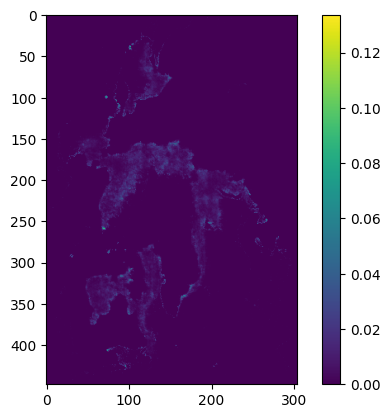

In [11]:
# Convert decoded_samples list to tensor and calculate variance across samples
samples_tensor = torch.stack(decoded_samples)  # Shape: [num_samples, batch, channel, height, width]
pixel_variance = torch.var(samples_tensor, dim=0)  # Variance across samples dimension

# Plot the variance
plt.figure()
plt.imshow(pixel_variance[0, 0, :, :].cpu().numpy())
plt.colorbar()
plt.show()

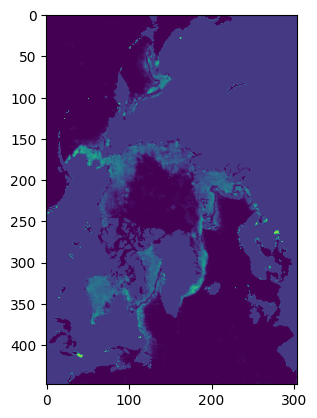

In [12]:
plt.imshow(abs(recon_batch[0, 0, :, :].cpu().numpy() - y[0, 0, :, :].cpu().numpy()))

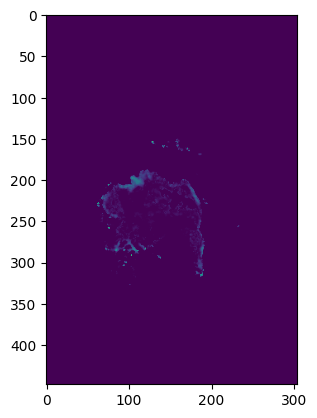

In [13]:
plt.imshow(abs(X[0, 0, 0, :, :].cpu().numpy() - y[0, 0, :, :].cpu().numpy()))